<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#FCN8s-(VGG-imageNet-weight)" data-toc-modified-id="FCN8s-(VGG-imageNet-weight)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>FCN8s (VGG imageNet weight)</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


## 하이퍼파라미터 세팅 및 seed 고정

In [3]:
batch_size = 18   # Mini-batch size
num_epochs = 6
learning_rate = 0.0001

In [4]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [7]:
%matplotlib inline

dataset_path = '../input/data'
anns_file_path = dataset_path + '/' + 'valid_data0.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 5284
Number of images: 655


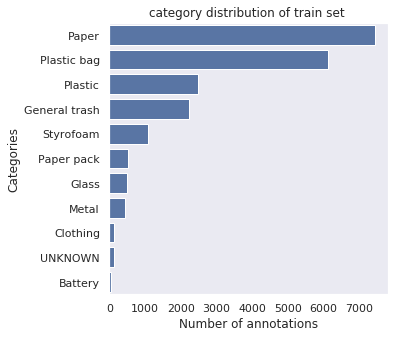

In [4]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [5]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [6]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [6]:
list(sorted_df.Categories)

['Backgroud',
 'UNKNOWN',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

## 데이터 전처리 함수 정의 (Dataset)

In [9]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [11]:
import sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
checker = skf.get_n_splits(dataset, dataset['annotations'])
print(checker)


5


In [33]:
annoo=[]
for k in range(len(dataset['annotations'])):
    annoo.append(dataset['annotations'][k]['category_id'])

In [44]:
print(folds[1][0])

[    0     1     2 ... 26392 26393 26395]


In [45]:
print(folds[1][1])

[    9    11    22 ... 26397 26398 26399]


In [47]:
dataset['images'][0]

{'license': 0,
 'url': None,
 'file_name': 'batch_01_vt/0002.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 0}

In [52]:
data_train_images = []
for k in folds[1][0]:
    a = dataset['annotations'][k]['image_id']
    for k in range(len(dataset['images'])):
        if dataset['images'][k]['id'] == a:
            data_train_images.append(k)

data_val_images = []
for k in folds[1][1]:
    a = dataset['annotations'][k]['image_id']
    for k in range(len(dataset['images'])):
        if dataset['images'][k]['id'] == a:
            data_val_images.append(k)

In [54]:
print(len(data_train_images))
tmp = set(data_train_images)
tmp2 = list(tmp)
print(len(tmp2))

print(len(data_val_images))
tmp3 = set(data_val_images)
tmp4 = list(tmp3)
print(len(tmp4))

21120
3089
5280
1976


In [55]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train_all.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            #A.Resize(256, 256),
                            ToTensorV2(),
                            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            
                            ])


# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
tdataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

train_dataset = torch.utils.data.Subset(tdataset, tmp2)
val_dataset = torch.utils.data.Subset(tdataset, tmp4)



# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)


loading annotations into memory...
Done (t=4.69s)
creating index...
index created!


In [38]:
folds=[]
for fold_index, (trn_idx, val_idx) in enumerate(skf.split(dataset['annotations'], annoo),1):
        folds.append((trn_idx, val_idx))

trn_idx = folds[1][0]
val_idx = folds[1][1]

train_ans = dataset['images'].iloc[trn_idx]
val_ans  = dataset['images'].iloc[val_idx]

print('\n## 교차검증: {0}'.format(fold))
print('학습 레이블 데이터 분포: \n', train_ans.value_counts())
print('검증 레이블 데이터 분포: \n', val_ans.value_counts())

ValueError: dictionary update sequence element #0 has length 7; 2 is required

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            #A.Resize(256, 256),
                            ToTensorV2(),
                            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            
                            ])

val_transform = A.Compose([
                          ToTensorV2(),
                          #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                          
                          ])

test_transform = A.Compose([
                           ToTensorV2(),
                           #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                           
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.93s)
creating index...
index created!
loading annotations into memory...
Done (t=1.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [59]:
print(len(train_loader))
print(len(val_loader))

194
124


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [9]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

NameError: name 'train_loader' is not defined

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {'Plastic bag', 9}]


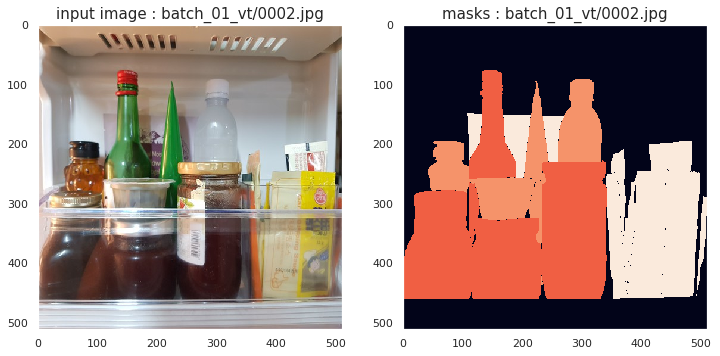

In [57]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


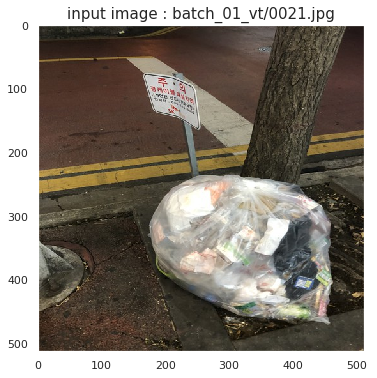

In [12]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### FCN8s (VGG imageNet weight)

In [18]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import vgg16
from efficientnet_pytorch import EfficientNet




class SegNet1(nn.Module):

    def __init__(self, num_classes):
        super(SegNet1,self).__init__()
        #self.pretrained_model = vgg16(pretrained = True)
        self.pretrained_model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=num_classes)
        def CBR(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU())

        def DCB(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU())
        
        #224x224
        #conv1
        self.conv1_1=CBR(3, 64, 3, 1, 1)
        self.conv1_2=CBR(64, 64, 3, 1, 1)
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True, return_indices=True)

        #112x112
        #conv2
        self.conv2_1=CBR(64, 128, 3, 1, 1)
        self.conv2_2=CBR(128, 128, 3, 1, 1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True, return_indices=True)

        #56x56
        #conv3
        self.conv3_1=CBR(128, 256, 3, 1, 1)
        self.conv3_2=CBR(256, 256, 3, 1, 1)
        self.conv3_3=CBR(256, 256, 3, 1, 1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True, return_indices=True)

        #28x28
        #conv4
        self.conv4_1=CBR(256, 512, 3, 1, 1)
        self.conv4_2=CBR(512, 512, 3, 1, 1)
        self.conv4_3=CBR(512, 512, 3, 1, 1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True, return_indices=True)

        #14x14
        #conv5
        self.conv5_1=CBR(512, 512, 3, 1, 1)
        self.conv5_2=CBR(512, 512, 3, 1, 1)
        self.conv5_3=CBR(512, 512, 3, 1, 1)
        self.pool5=nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True, return_indices=True)

        #14x14
        #unpool5
        self.unpool5=nn.MaxUnpool2d(2, stride=2)
        self.deconv5_1=CBR(512, 512, 3, 1, 1)
        self.deconv5_2=CBR(512, 512, 3, 1, 1)
        self.deconv5_3=CBR(512, 512, 3, 1, 1)

        #28x28
        #unpool4
        self.unpool4=nn.MaxUnpool2d(2, stride=2)
        self.deconv4_1=CBR(512, 512, 3, 1, 1)
        self.deconv4_2=CBR(512, 512, 3, 1, 1)
        self.deconv4_3=CBR(512, 256, 3, 1, 1)

        #56x56
        #unpool3
        self.unpool3=nn.MaxUnpool2d(2, stride=2)
        self.deconv3_1=CBR(256, 256, 3, 1, 1)
        self.deconv3_2=CBR(256, 256, 3, 1, 1)
        self.deconv3_3=CBR(256, 128, 3, 1, 1)

        #112x112
        #unpool2
        self.unpool2=nn.MaxUnpool2d(2, stride=2)
        self.deconv2_1=CBR(128, 128, 3, 1, 1)
        self.deconv2_2=CBR(128, 64, 3, 1, 1)

        #224x224
        #unpool1
        self.unpool1=nn.MaxUnpool2d(2, stride=2)
        self.deconv1_1=CBR(64, 64, 3, 1, 1)
        
        #Score
        self.score_fr = nn.Conv2d(64, num_classes, 3, 1, 1, 1)

    
    def forward(self, x):
        h=self.conv1_1(x)
        h=self.conv1_2(h)
        h, pool1_indices=self.pool1(h)

        h=self.conv2_1(h)
        h=self.conv2_2(h)
        h, pool2_indices=self.pool2(h)

        h=self.conv3_1(h)
        h=self.conv3_2(h)
        h=self.conv3_3(h)
        h, pool3_indices=self.pool3(h)

        h=self.conv4_1(h)
        h=self.conv4_2(h)
        h=self.conv4_3(h)
        h, pool4_indices=self.pool4(h)

        h=self.conv5_1(h)
        h=self.conv5_2(h)
        h=self.conv5_3(h)
        h, pool5_indices=self.pool5(h)

        h=self.unpool5(h, pool5_indices)
        h=self.deconv5_1(h)
        h=self.deconv5_2(h)
        h=self.deconv5_3(h)
        
        h=self.unpool4(h, pool4_indices)
        h=self.deconv4_1(h)
        h=self.deconv4_2(h)
        h=self.deconv4_3(h)

        h=self.unpool3(h, pool3_indices)
        h=self.deconv3_1(h)
        h=self.deconv3_2(h)
        h=self.deconv3_3(h)

        h=self.unpool2(h, pool2_indices)
        h=self.deconv2_1(h)
        h=self.deconv2_2(h)

        h=self.unpool1(h, pool1_indices)
        h=self.deconv1_1(h)

        output = self.score_fr(h)

        return output

In [19]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = SegNet1(num_classes=12)
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

Loaded pretrained weights for efficientnet-b2
input shape :  torch.Size([1, 3, 512, 512])


RuntimeError: Given groups=1, weight of size 32 3 3 3, expected input[1, 64, 513, 513] to have 3 channels, but got 64 channels instead

In [60]:
import segmentation_models_pytorch as smp 

aux_params=dict(
    pooling='avg',
    dropout=0.7,
    activation=None,
    classes=12,
)

model = smp.DeepLabV3Plus(
    encoder_name="timm-efficientnet-b0",
    encoder_depth=5,
    encoder_weights="noisy-student",
    encoder_output_stride=16, 
    decoder_channels=512, 
    decoder_atrous_rates=(6, 18, 30), 
    in_channels=3, 
    classes=12, 
    activation=None, 
    upsampling=4, 
    aux_params=aux_params,
)

model = model.to(device)

## train, validation, test 함수 정의

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [11]:
import segmentation_models_pytorch as smp 
import sklearn
from sklearn.model_selection import StratifiedKFold

def train(num_epochs, saved_dir, val_every, device):
    # -- dataset
    data_dir = '../input/data'
    anns_file_path = data_dir + '/' + 'train_all.json'
    # Read annotations
    with open(anns_file_path, 'r') as f:
        dataset = json.loads(f.read())

    anno=[]
    for k in range(len(dataset['annotations'])):
        anno.append(dataset['annotations'][k]['category_id'])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    folds=[]
    for fold_index, (trn_idx, val_idx) in enumerate(skf.split(dataset['annotations'], anno),1):
        folds.append((trn_idx, val_idx))

    best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
    for fold in range(5):
        print(f'[folds: {fold}]')
        # cuda cache 초기화
        torch.cuda.empty_cache()

        # -- augmentation
        #transform_module = getattr(import_module("dataset"), args.augmentation[1])  # 0: CustomAugmentation
        #transform = transform_module()
        transform = A.Compose([
                            #A.Resize(128, 128),
                            ToTensorV2(),
                            ])

        # total dataset
        total_dataset = CustomDataLoader(data_dir=anns_file_path, mode='train', transform=transform)

        # get image number from splited annotation info(train:folds[fold][0])
        data_train_images = []
        for k in folds[fold][0]:
            a = dataset['annotations'][k]['image_id']
            for k in range(len(dataset['images'])):
                if dataset['images'][k]['id'] == a:
                    data_train_images.append(k)
        # get image number from splited annotation info(val:folds[fold][1])
        data_val_images = []
        for k in folds[fold][1]:
            a = dataset['annotations'][k]['image_id']
            for k in range(len(dataset['images'])):
                if dataset['images'][k]['id'] == a:
                    data_val_images.append(k)

        print(len(data_train_images))
        tmp = set(data_train_images)
        train_set = list(tmp)
        print(len(train_set))

        print(len(data_val_images))
        tmp2 = set(data_val_images)
        val_set = list(tmp2)
        print(len(val_set))

        
        train_dataset = torch.utils.data.Subset(total_dataset, train_set)
        val_dataset = torch.utils.data.Subset(total_dataset, val_set)


        # -- data_loader
        train_loader = DataLoader(dataset=train_dataset, 
                                    batch_size=18,
                                    shuffle=True,
                                    num_workers=4,
                                    collate_fn=collate_fn)

        val_loader = DataLoader(dataset=val_dataset, 
                                    batch_size=18,
                                    shuffle=False,
                                    num_workers=4,
                                    collate_fn=collate_fn)
        print('data loader finished')

        aux_params=dict(
            pooling='avg',
            dropout=0.7,
            activation=None,
            classes=12,
        )

        model = smp.DeepLabV3Plus(
            encoder_name="timm-efficientnet-b0",
            encoder_depth=5,
            encoder_weights="noisy-student",
            encoder_output_stride=16, 
            decoder_channels=512, 
            decoder_atrous_rates=(6, 18, 30), 
            in_channels=3, 
            classes=12, 
            activation=None, 
            upsampling=4, 
            aux_params=aux_params,
        )

        model = model.to(device)

        # Loss function 정의
        #criterion = nn.CrossEntropyLoss()
        criterion = smp.losses.FocalLoss('multiclass')

        # Optimizer 정의
        optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)

        print('Start training..')
        best_loss = 9999999
        best_mIoU = 0
        for epoch in range(num_epochs):
            model.train()
            for step, (images, masks, _) in enumerate(tqdm(train_loader)):
                images = torch.stack(images)       # (batch, channel, height, width)
                masks = torch.stack(masks).long()  # (batch, channel, height, width)
                
                # gpu 연산을 위해 device 할당
                images, masks = images.to(device), masks.to(device)
            
                # inference
                outputs = model(images)
                
                (a, b)=outputs  #a는 위치 예측, b는 라벨 예측
                loss = criterion(a, masks)
                

                # loss 계산 (cross entropy loss)
                #loss = criterion(outputs, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # step 주기에 따른 loss 출력
                if (step + 1) % 12 == 0: #batch8-25
                    current_lr = get_lr(optimizer)
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                        epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
                    print(f"lr {current_lr}")
                    wandb.log({
                    "Train Loss": loss,

                    })
            scheduler.step()
            
            # validation 주기에 따른 loss 출력 및 best model 저장
            if (epoch + 1) % val_every == 0:
                avrg_loss, mIoU = validation(epoch + 1, model, val_loader, criterion, device)
                if mIoU > best_mIoU:
                    print('Best performance at epoch: {}'.format(epoch + 1))
                    print('Save model in', saved_dir)
                    if avrg_loss < best_loss:
                        best_loss = avrg_loss
                    save_model(model, saved_dir, f"{fold}_epoch{epoch}_{avrg_loss:4.4}_{mIoU:4.4}_best.pt")
                wandb.log({
                    "Validation avg Loss": avrg_loss,
                    "Validation avg mIoU": mIoU
                })

In [12]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()

    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            (a, b) = outputs
            loss = criterion(a, masks)
            total_loss += loss
            cnt += 1
            
            a = torch.argmax(a.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), a, n_class=12)[2]
            mIoU_list.append(mIoU)

            wandb.log({
                "Validation Loss": loss,
                "Validation mIoU": mIoU
            })
            
        avrg_loss = total_loss / cnt
        mean_mIoU = np.mean(mIoU_list)
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, mean_mIoU))

    return avrg_loss, mean_mIoU

## 모델 저장 함수 정의

In [13]:
# 모델 저장 함수 정의
val_every = 1 

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [24]:
# Loss function 정의
#criterion = nn.CrossEntropyLoss()
criterion = smp.losses.FocalLoss('multiclass')

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)

NameError: name 'model' is not defined

In [14]:
import wandb
import argparse
wandb.init(project="jjay")
wandb.run.name='DeepLabV3Plus-timm-efficientnet-b0-fold5'
wandb.run.save()

wandb.config.update({"seed":42, "epochs": 6, "batch_size": 18, "dataset": 'given', "augmentation": None, "model":'DeepLabV3Plus-timm-efficientnet-b4', "optimizer":'Adam', "lr":1e-4, "criterion":'Focal', 'step lr': 1, 'gamma': 0.5})
#print("1")
#wandb.watch(model)
#print("2")

train(6, saved_dir, val_every, device)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pstage12 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


1<04:52,  3.32s/it]Epoch [2/6], Step [84/172], Loss: 0.1947
lr 5e-05
 56%|█████▌    | 96/172 [05:20<04:10,  3.30s/it]Epoch [2/6], Step [96/172], Loss: 0.2518
lr 5e-05
 63%|██████▎   | 108/172 [06:00<03:35,  3.37s/it]Epoch [2/6], Step [108/172], Loss: 0.3078
lr 5e-05
 70%|██████▉   | 120/172 [06:41<02:58,  3.43s/it]Epoch [2/6], Step [120/172], Loss: 0.2874
lr 5e-05
 77%|███████▋  | 132/172 [07:21<02:12,  3.30s/it]Epoch [2/6], Step [132/172], Loss: 0.1997
lr 5e-05
 84%|████████▎ | 144/172 [08:02<01:35,  3.41s/it]Epoch [2/6], Step [144/172], Loss: 0.2858
lr 5e-05
 91%|█████████ | 156/172 [08:42<00:53,  3.36s/it]Epoch [2/6], Step [156/172], Loss: 0.1987
lr 5e-05
 98%|█████████▊| 168/172 [09:23<00:13,  3.34s/it]Epoch [2/6], Step [168/172], Loss: 0.1695
lr 5e-05
  0%|          | 0/172 [00:00<?, ?it/s]Validation #2  Average Loss: 0.1734, mIoU: 0.3558
Best performance at epoch: 2
Save model in ./saved
  7%|▋         | 12/172 [00:40<08:47,  3.30s/it]Epoch [3/6], Step [12/172], Loss: 0.2424
lr 2

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512, 1, 1])

## 저장된 model 불러오기 (학습된 이후) 

In [21]:
# best model 저장된 경로
model_path = './saved/DeepLabV3Plus_best_model(timm-efficientnet-b0-mid).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

<All keys matched successfully>

In [15]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

AttributeError: 'tuple' object has no attribute 'squeeze'

## submission을 위한 test 함수 정의

In [22]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            (a, b) = outs
            oms = torch.argmax(a.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [23]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Baseline_DeepLabV3Plus(timm-efficientnet-b0).csv", index=False)

100%|██████████| 53/53 [19:01<00:00, 21.55s/it]
End prediction.


## Reference



In [16]:
data_dir = '../input/data'
anns_file_path = data_dir + '/' + 'train_all.json'
# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

anno=[]
for k in range(len(dataset['annotations'])):
    anno.append(dataset['annotations'][k]['category_id'])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for fold_index, (trn_idx, val_idx) in enumerate(skf.split(dataset['annotations'], anno),1):
    folds.append((trn_idx, val_idx))

best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
for fold in range(5):
    print(f'[folds: {fold}]')
    
    data_train_images = []
    for k in folds[fold][0]:
        a = dataset['annotations'][k]['image_id']
        for k in range(len(dataset['images'])):
            if dataset['images'][k]['id'] == a:
                data_train_images.append(k)
    # get image number from splited annotation info(val:folds[fold][1])
    data_val_images = []
    for k in folds[fold][1]:
        a = dataset['annotations'][k]['image_id']
        for k in range(len(dataset['images'])):
            if dataset['images'][k]['id'] == a:
                data_val_images.append(k)

    print(len(data_train_images))
    tmp = set(data_train_images)
    train_set = list(tmp)
    print(len(train_set))

    print(len(data_val_images))
    tmp2 = set(data_val_images)
    val_set = list(tmp2)
    print(len(val_set))
    print('-------------------------')

[folds: 0]
21120
3081
5280
2009
-------------------------
[folds: 1]
21120
3089
5280
1976
-------------------------
[folds: 2]
21120
3097
5280
1967
-------------------------
[folds: 3]
21120
3081
5280
1953
-------------------------
[folds: 4]
21120
3098
5280
1973
-------------------------


In [7]:
num = [3081, 2009, 3089, 1976, 3097, 1967, 3081, 1953, 3098, 1973]
a = 15.0
for k in num:
    print(k/a)

205.4
133.93333333333334
205.93333333333334
131.73333333333332
206.46666666666667
131.13333333333333
205.4
130.2
206.53333333333333
131.53333333333333


In [17]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 26400
Number of images: 3272


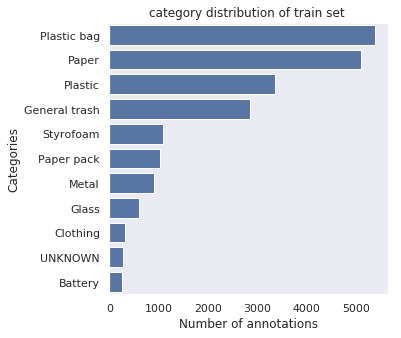

In [18]:
annss = []
for k in data_train_images:
    annss.append(anns[k])


# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in annss:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")